In [ ]:
##These are my personal machine learning import statements, they cover most of what I regularly need for CV
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


#we can use this to set our device. If we have a GPU available we should probably use it. 
#currently the code is not written to make use of mulitple GPUs and will default to the 
#first available GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#these set cuda backend parameters so that we should get more reproducable results. 
#some cuda functions will prefer non-deterministic backends in some cases, eg. conv2d,
#which we would like to fix to slower deterministic backends for sharing reproducable 
#experiments
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)


#here we define our convolutional neural network
#it uses 4 convolutional layers to downsample a 32x32 NN
#it makes usse of an all convolutional network in the style 
#of discriminator suggested in  “Unsupervised Representation 
#Learning with Deep Convolutional Generative Adversarial Networks”
#by Radford et. al. 
# 
# input batch_size x 32 x 32
#         ==> 1st convolution layer 
#       8 x 16 x 16 
#         ==> batchnorm2d, leakyrelu, 2nd convolution layer
#       16 x 8  x  8 
#         ==> batchnorm2d, leakyrelu, 3nd convolution layer
#       32 x 4  x  4 
#         ==> batchnorm2d, leakyrelu, 4nd convolution layer
#       10 x 1  x  1  output --> no sigmoid activation, I found it trains faster without it
class CNN(nn.Module): 
    def __init__(self,feat_dim): 
        super(CNN,self).__init__() 
        #we define our CNN layers
        self.main = nn.Sequential(
                    #input batch_size x 1 x 32 x 32 tensor 
            
                    nn.Conv2d(1,feat_dim,4,stride= 2,padding = 1),
                    #output batch_size x feat_dim x 16 x 16
            
                    nn.BatchNorm2d(feat_dim),
                    nn.LeakyReLU(negative_slope = .2, inplace = True), 
                    nn.Conv2d(feat_dim,feat_dim*2,4,stride = 2, padding = 1),
                    #output batch_size x feat_dim*2 x 8 x 8
            
                    nn.BatchNorm2d(feat_dim*2),
                    nn.LeakyReLU(negative_slope = .2, inplace = True),
                    nn.Conv2d(feat_dim*2,feat_dim*4,4,stride = 2 ,padding = 1),
                    #output batch_size x feat_dim*4 x 4 x 4
            
                    nn.BatchNorm2d(feat_dim*4),
                    nn.LeakyReLU(negative_slope = .2, inplace = True),
                    nn.Conv2d(feat_dim*4,10,4,1,0)
                    #output batch_size X 10 x 1 x 1
                    )
    def forward(self,x): 
        #pass through sequential NN
        x = self.main(x)
        #output is batch_size X 10 x 1 x 1
        #need to output as batch_size x 10 
        return x[:,:,0,0]
    
#initialize our matrix in style of DCGAN 
def weights_init(m): 
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: 
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1: 
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)
print(device)
print(device == torch.device('cuda:0'))

cuda:0
True


Initial loss : 2.3591
Epoch [1/1], Step [469/938], test Loss: 0.0796
Epoch [1/1], Step [938/938], test Loss: 0.1809


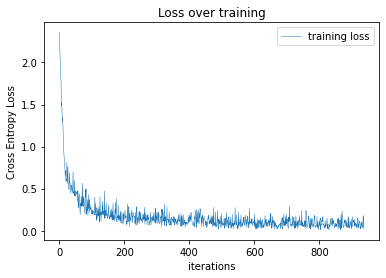

pass rate for trained network = 98.1400%


In [ ]:
#define our global parameters

#number of epochs to train for
num_epochs = 1 #found sufficient convergence after 1 epoch of training

#batch sizes for training and validation
training_batch_size = 64 #I found that a batch size of 64 led to sufficient convergence quickly
validation_batch_size = 4098 #validating over larger swatches at once

#size of feature map dimension in CNN
num_features = 8 #choose power of two greater than 8, I found 8 achieves about 98% pass rate

#boolean, whether or not to plot loss vs iterations 
plot_loss = True

#int, number of times to iterate through the test set of data for validation 
#     we can iterate through it more times to have more confidence in the 
#     trained model
num_val_tests = 10


#import data for MNIST 

#transform to send PIL images to tensors and resize 
# 28 x 28 --> 32 x 32 
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
train_data = datasets.MNIST(
    root = 'data', 
    train = True, 
    transform = transform,
    download = True
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transform 
)

#define a dictionary of loaders on train set and test set
# if using GPU want to enable pin_memory --> 
#    it allows preloading of datasets into GPU memory which reduces training overhead. 
#    in my experiments disabling pin memory when GPU is used increased training times by 
#    50%
if (device == torch.device('cuda:0')): 
    loaders = {'train': torch.utils.data.DataLoader(train_data, batch_size = training_batch_size, shuffle = True,num_workers = 1, pin_memory = True), 
          'test' : torch.utils.data.DataLoader(test_data, batch_size = validation_batch_size, shuffle = True,num_workers = 1, pin_memory = True)}
else: 
    loaders = {'train': torch.utils.data.DataLoader(train_data, batch_size = training_batch_size, shuffle = True,num_workers = 1), 
          'test' : torch.utils.data.DataLoader(test_data, batch_size = validation_batch_size, shuffle = True,num_workers = 1)}

#define model and apply initialization weights
torch.cuda.empty_cache()
cnn = CNN(num_features) 
cnn.to(device)
cnn.apply(weights_init)


#we want to use Cross entropy loss for multiple output classification
loss_func = nn.CrossEntropyLoss()
#we can use any gradient descent method. This model trains easily
#so we want to accuracy of SGD over the speed of Adams gradient
#descent
optimizer = optim.SGD(cnn.parameters(),lr = .01, momentum = .8)



#Training loop
#   num_epochs       --> int, number of times to iterate over training data 
#   cnn              --> model to train 
#   loaders          --> loaders formatted as created above to train on 
#   optimizer        --> optimizer used for computing weight updates 
#   loss_func        --> function used to optimize over 
#   prints_per_epoch --> int, frequency for printing output
#   output_loss      --> bool, whether or not to return array containing running loss over training
def train(num_epochs, model ,loaders,optimizer, 
          loss_func,prints_per_epoch, output_loss = False
         ): 
    total_step = len(loaders['train'])#parameter for printing output
    model.train()
    #empty GPU cache before training if using
    if (device == torch.device('cuda:0')): 
        torch.cuda.empty_cache()
            
    #create numpy array to store running errors in if requested 
    #ie for creating plot of losses after training etc...
    if output_loss: 
        err = np.zeros(total_step*num_epochs)
    for epoch in range(num_epochs): 
        for i ,(images,labels) in enumerate(loaders['train']): 
            
            #send our images and training labels to either the 
            #cpu or gpu depending on what we are using 
            b_x = Variable(images).to(device)
            b_y = Variable(labels).to(device)
            
            #compute the model's output
            output = model(b_x)
            
            #compute the loss
            loss = loss_func(output,b_y) 
            
            #zero out the gradient and update our weights
            #and biases
            cnn.zero_grad()
            loss.backward() 
            optimizer.step() 

            #print out progress at rate of prints_per_epoch approximately
            if i == 0 & epoch == 0: 
                print('Initial loss : {:.4f}'.format(loss.item()))
            if (i+1) % int(total_step//prints_per_epoch) == 0: 
                print('Epoch [{}/{}], Step [{}/{}], test Loss: {:.4f}' 
                        .format(epoch + 1, num_epochs, i + 1, total_step, loss.mean().item()))
            pass
            
            #create loss array if requested, default does not return
            if output_loss: 
                err[i+epoch*total_step] = loss.mean().item()
    pass
    
    if output_loss: 
        return cnn, err
    else: 
        return cnn
    
#function to plot losses vs. iterations
def plot_lossses(loss): 
    fig,ax = plt.subplots()
    ax.plot(err,lw = .5,label = 'training loss') 
    ax.set_xlabel('iterations')
    ax.set_ylabel('Cross Entropy Loss') 
    ax.legend() 
    ax.set_title('Loss over training')
    plt.show()

#function to validate the trained model on 
#this will return the top-1 pass rate of the model
#  model     --> CNN model 
#  loss_func --> desired loss function 
#  num_tests --> int, number of times to iterate through 
#                the test data (since leakyReLU is nondeterministic)
def validate(model, loss_func, num_tests,val_batch_size):
    top_1 = np.zeros([len(loaders['test'])*(num_tests),val_batch_size])
    act_out = np.zeros([len(loaders['test'])*(num_tests),val_batch_size])
    val_loader_size = len(loaders['test'])
    for j in range(num_tests):
        for i ,(images,labels) in enumerate(loaders['test']): 

            b_x = Variable(images).to(device)
            b_y = Variable(labels).to(device)

            output = model(b_x)
            top_1[i + j*val_loader_size,:len(b_y)]  = np.argmax(output.detach().cpu().numpy(),axis = 1)
            act_out[i + j*val_loader_size,:len(b_y)] = b_y.detach().cpu().numpy()
    pass_rate = 100 -((len(np.where(top_1 - act_out != 0)[1])/(len(loaders['test'].dataset)*num_tests)))*100
    results = pass_rate
    print('pass rate for trained network = {:3.4f}%'.format(results))
    
#run the training loop and update the model with trained parameters
if plot_loss: 
    #run training loop
    cnn,err = train(num_epochs,cnn,loaders,optimizer, loss_func,2,plot_loss) 
    
    #create output figure
    plot_lossses(err)    
else: 
    cnn = train(num_epochs,cnn,loaders,optimizer, loss_func,2,plot_loss) 
    
#compute the validation
validate(cnn, loss_func,1,validation_batch_size)
